In [754]:
from tensorflow.keras.models import load_model
import keras
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import math

# *Load model and set parameters*

In [755]:
model = load_model('/Users/wangfan/Documents/wukm/Uncertainty Projects/NEO/NEO.keras')

X_test = np.load('/Users/wangfan/Documents/wukm/Uncertainty Projects/NEO/X_test_NEO.npy')
y_test = np.load('/Users/wangfan/Documents/wukm/Uncertainty Projects/NEO/y_test_NEO.npy')
num_observations = 100
num_classes = 10

In [756]:
#modify length to make it fit the model

#X_test_padded = np.pad(X_test, ((0, 0), (0, 13)), mode='constant', constant_values=0)

In [757]:
#print(X_test_padded.shape)

In [758]:
#max_values = np.max(X_test_padded, axis=0) * 1000000

In [759]:
#print(max_values.round().astype(np.int64))

In [760]:
#print(X_test_padded)

In [761]:
"""
scaling_factor = 1000000  # Choose an appropriate factor
X_test_scaled = (X_test_padded * scaling_factor).round().astype(np.int64)
X_test_scaled[:,5] = X_test_scaled[:,5] / 100
X_test_scaled[:,6] = X_test_scaled[:,6] / 100
X_test_scaled[:,8] = X_test_scaled[:,8] / 100
X_test_scaled[:,9] = X_test_scaled[:,9] / 10000000
X_test_scaled[:,10] = X_test_scaled[:,10] / 10
X_test_scaled[:,11] = X_test_scaled[:,11] / 10

"""

'\nscaling_factor = 1000000  # Choose an appropriate factor\nX_test_scaled = (X_test_padded * scaling_factor).round().astype(np.int64)\nX_test_scaled[:,5] = X_test_scaled[:,5] / 100\nX_test_scaled[:,6] = X_test_scaled[:,6] / 100\nX_test_scaled[:,8] = X_test_scaled[:,8] / 100\nX_test_scaled[:,9] = X_test_scaled[:,9] / 10000000\nX_test_scaled[:,10] = X_test_scaled[:,10] / 10\nX_test_scaled[:,11] = X_test_scaled[:,11] / 10\n\n'

In [762]:
#X_test_scaled.dtype

# *Monte-Carlo Dropout*

In [763]:
observations = []

for i in range(num_observations):
    print(i)
    keras.utils.set_random_seed(i)
    observations.append(model(X_test, training=True))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


In [764]:
observations = np.array(observations)
observations.shape

(100, 84550, 2)

In [765]:
observations_MC = np.mean(observations,axis = 0)
observations_MC.shape

(84550, 2)

**Special Case**

In [766]:
#observations = np.load('/Users/wangfan/Documents/wukm/Uncertainty Projects/FIA/obs_FIA_t.npy')
#y_test = np.load('/Users/wangfan/Documents/wukm/Uncertainty Projects/FIA/y_test_FIA_t.npy')

In [767]:
#observations.shape

In [768]:
#y_test.shape

In [769]:
#preds = np.argmax(observations,axis = 1)
#preds_MC = np.argmax(observations_MC,axis = 1)

#print(preds.shape)
#print(preds_MC.shape)

# *Predictions*

In [770]:
preds = np.argmax(observations[0,:,:],axis = 1)
preds_MC = np.argmax(observations_MC,axis = 1)

print(preds.shape)
print(preds_MC.shape)

(84550,)
(84550,)


# *Uncertainty Quantifications*

In [771]:
# Misclassification Probability
MP = []
for i in range(observations.shape[1]):
    MP.append(1-observations[0,i,preds[i]])
print(len(MP))

MP_MC = []
for i in range(observations.shape[1]):
    MP_MC.append(1-observations_MC[i,preds_MC[i]])
print(len(MP_MC))

84550
84550


In [772]:
# Information Entropy
Entropy = []
for i in range(observations.shape[1]):
  Entropy.append(-1*np.sum(observations[0,i,:]*np.log2(observations[0,i,:])))
print(len(Entropy))

Entropy_MC = []
for i in range(observations.shape[1]):
  Entropy_MC.append(-1*np.sum(observations_MC[i,:]*np.log2(observations_MC[i,:])))
print(len(Entropy_MC))

/var/folders/4s/841zkl6n27j9pb1g14wz2dkm0000gn/T/ipykernel_60158/2502482400.py:4: RuntimeWarning: divide by zero encountered in log2
  Entropy.append(-1*np.sum(observations[0,i,:]*np.log2(observations[0,i,:])))
/var/folders/4s/841zkl6n27j9pb1g14wz2dkm0000gn/T/ipykernel_60158/2502482400.py:4: RuntimeWarning: invalid value encountered in multiply
  Entropy.append(-1*np.sum(observations[0,i,:]*np.log2(observations[0,i,:])))


84550
84550


In [773]:
# Standard Deviation of the Predicted Probabilities of the Predicted Class
DPP = []
for i in range(observations.shape[1]):
    DPP.append(np.std(observations[:,i,preds_MC[i]]))
DPP = (DPP-np.min(DPP))/(np.max(DPP)-np.min(DPP))
len(DPP)

84550

In [774]:
# Modal Prediction

RC = np.argmax(observations[:,:,:],axis = 2)
m = stats.mode(RC)
pc = m.mode
    
n_min = num_observations/num_classes + 1
u_max = (num_observations-n_min) / num_observations
n_miss = 100 - m.count
MoP = n_miss / (num_observations*u_max)
MoP = MoP.tolist()
len(MoP)

84550

**Ideal Line**

In [775]:
def Idealline_generate(uncertainty, acc):
    id_line = []
    threshold = int(uncertainty * 10)  # Cast to int for range
    x = 0.1

    # First segment
    for i in range(0, threshold):
        id_line.append(((acc - 1) / uncertainty) * (x - 0.1) + 1)
        x += 0.1

    # Second segment
    for i in range(threshold, 10):  # Correct range for second loop
        id_line.append(acc - (acc / ((1 - uncertainty) ** 2)) * ((x - uncertainty) ** 2))
        x += 0.1
    
    return id_line

#IL = Idealline_generate(0.3, 0.95)

In [776]:
import math  # Ensure math is imported

def Idealline_sigmoid(k, x_0):
    id_line = []
    x = 0.1
    for i in range(10):
        id_line.append(1 - 1 / (1 + math.exp(-k * (x - x_0))))  # Ensure math.exp is a function
        x += 0.1
    return id_line

IL = Idealline_sigmoid(12, 0.6)


In [777]:
print(IL)

[0.9975273768433652, 0.9918374288468401, 0.9734030064231342, 0.9168273035060776, 0.7685247834990176, 0.5, 0.23147521650098246, 0.08317269649392234, 0.026596993576865957, 0.008162571153159881]


# *Uncertainty Predicts Accuracy*

In [778]:
T_F = []
T_F_MC = []

for i in range(observations.shape[1]):
    if(preds[i] == np.argmax(y_test[i])):
        T_F.append('T')
    else:
        T_F.append('F')
    if(preds_MC[i] == np.argmax(y_test[i])):
        T_F_MC.append('T')
    else:
        T_F_MC.append('F')

print(T_F)
print(T_F_MC)

['T', 'T', 'T', 'T', 'T', 'T', 'T', 'T', 'F', 'T', 'T', 'F', 'T', 'T', 'T', 'T', 'T', 'F', 'T', 'F', 'T', 'F', 'T', 'T', 'T', 'T', 'T', 'T', 'F', 'T', 'T', 'T', 'T', 'T', 'T', 'T', 'T', 'T', 'T', 'T', 'T', 'F', 'F', 'T', 'F', 'T', 'T', 'F', 'T', 'F', 'T', 'T', 'T', 'T', 'T', 'T', 'T', 'T', 'T', 'T', 'T', 'T', 'T', 'T', 'T', 'T', 'T', 'T', 'T', 'T', 'F', 'T', 'T', 'T', 'T', 'T', 'T', 'T', 'T', 'T', 'T', 'F', 'T', 'T', 'T', 'T', 'T', 'F', 'T', 'T', 'T', 'T', 'T', 'T', 'T', 'T', 'F', 'T', 'T', 'T', 'T', 'T', 'T', 'T', 'T', 'T', 'T', 'F', 'T', 'T', 'T', 'T', 'T', 'F', 'F', 'T', 'F', 'T', 'T', 'T', 'T', 'T', 'T', 'T', 'F', 'T', 'T', 'T', 'T', 'T', 'T', 'T', 'T', 'F', 'T', 'T', 'F', 'T', 'T', 'T', 'T', 'T', 'T', 'T', 'T', 'T', 'T', 'F', 'T', 'T', 'T', 'T', 'F', 'T', 'T', 'T', 'T', 'T', 'T', 'T', 'T', 'T', 'T', 'T', 'T', 'F', 'T', 'T', 'F', 'T', 'T', 'T', 'T', 'T', 'T', 'T', 'T', 'F', 'T', 'T', 'F', 'T', 'T', 'T', 'F', 'T', 'T', 'T', 'T', 'T', 'F', 'T', 'T', 'T', 'T', 'T', 'T', 'T', 'F', 'F',

In [779]:
def cal_bin(uc_list,T_F_list,slices,acc):
    temp_List = []
    u_List = []
    a = 0
    b = 1/slices

    for j in range(slices):

        for i in range(len(uc_list)):

            if a <= uc_list[i] <= b:
                temp_List.append(T_F_list[i])

        if acc:
            if(len(temp_List)==0):
                u_List.append(0)
            else:
                u_List.append(temp_List.count('T')/len(temp_List))
        else:
            u_List.append(len(temp_List))
        temp_List =[]

        a = a+1/slices
        b = b+1/slices

    print(u_List)
    return u_List

In [780]:
uList_MP = cal_bin(MP,T_F,10,True)
uList_MP_MC = cal_bin(MP_MC,T_F,10,True)
uList_Entropy = cal_bin(Entropy,T_F,10,True)
uList_Entropy_MC = cal_bin(Entropy_MC,T_F_MC,10,True)
uList_DPP = cal_bin(DPP,T_F_MC,10,True)
uList_MoP = cal_bin(MoP,T_F,10,True)

[0.9967142396387679, 0.8331360946745562, 0.7337796907380838, 0.6619393139841688, 0.5610278372591007, 0, 0, 0, 0, 0]
[0.9982457201621197, 0.851878612716763, 0.744229931775294, 0.6449162011173184, 0.5248833592534993, 0, 0, 0, 0, 0]
[0.9994621015458733, 0.9936194895591647, 0.9768957345971564, 0.9653846153846154, 0.9284984678243106, 0.8837429111531191, 0.8134741075917546, 0.7548643658571226, 0.7193166885676742, 0.6244770996460367]
[0.9998427284369453, 0.9939309056956116, 0.9925619834710744, 0.9744990892531876, 0.949244060475162, 0.8989690721649485, 0.8086003372681282, 0.8029772329246935, 0.7275057677518585, 0.608443021463299]
[0.9996473051912267, 0.7712749497137552, 0.7323665893271462, 0.6017699115044248, 0.5278276481149012, 0.6424517593643587, 0.8647214854111406, 0.9473684210526315, 1.0, 1.0]
[0.8967746767187578, 0.6019230769230769, 0.5931882686849574, 0.5409429280397022, 0.4928, 0.5466321243523317, 0, 0, 0, 0]


In [781]:
uList_MP_count = cal_bin(MP,T_F,10,False)
uList_MP_MC_count = cal_bin(MP_MC,T_F,10,False)
uList_Entropy_count = cal_bin(Entropy,T_F_MC,10,False)
uList_Entropy_MC_count = cal_bin(Entropy_MC,T_F_MC,10,False)
uList_DPP_count = cal_bin(DPP,T_F_MC,10,False)
uList_MoP_count = cal_bin(MoP,T_F,10,False)

[49608, 4225, 18819, 9096, 2802, 0, 0, 0, 0, 0]
[49593, 2768, 20667, 8950, 2572, 0, 0, 0, 0, 0]
[42759, 3448, 1688, 1040, 979, 1058, 1989, 7041, 15220, 9323]
[44509, 2142, 1210, 1098, 926, 970, 1186, 4568, 19505, 8433]
[45365, 25852, 8620, 1921, 1114, 881, 754, 38, 2, 2]
[80116, 1560, 1057, 806, 625, 386, 0, 0, 0, 0]


# *Plot* 

**All**

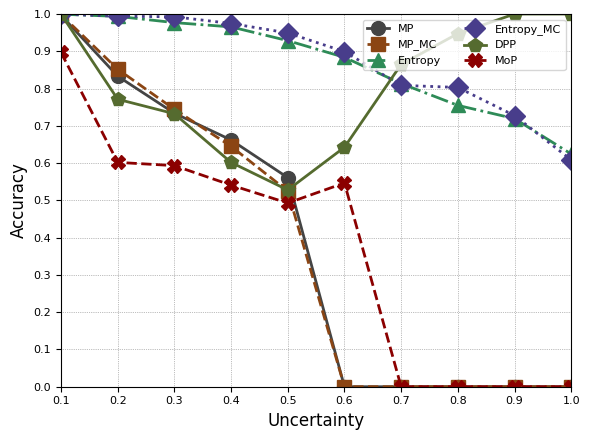

In [782]:
# Prepare the plot
x_values = np.arange(0.1, 1.1, 0.1)

plt.figure(figsize=(6, 4.5), dpi=100)
plt.xlabel('Uncertainty', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.xticks(np.arange(0, 1.1, 0.1), fontsize=8)
plt.yticks(np.arange(0, 1.1, 0.1), fontsize=8)
plt.ylim(0, 1)
plt.xlim(0.1, 1)
plt.grid(True, which='both', linestyle=':', linewidth=0.5, color='gray')

# Define a list of dark colors
dark_colors = ['#444444', '#8B4513', '#2E8B57', '#483D8B', '#556B2F', '#8B0000']

# Plot each line with a unique color, linestyle, and marker
line1, = plt.plot(x_values, uList_MP, color=dark_colors[0], linestyle='-', marker='o', markersize=10, linewidth=2, label='MP')
line2, = plt.plot(x_values, uList_MP_MC, color=dark_colors[1], linestyle='--', marker='s', markersize=10, linewidth=2, label='MP_MC')
line3, = plt.plot(x_values, uList_Entropy, color=dark_colors[2], linestyle='-.', marker='^', markersize=10, linewidth=2, label='Entropy')
line4, = plt.plot(x_values, uList_Entropy_MC, color=dark_colors[3], linestyle=':', marker='D', markersize=10, linewidth=2, label='Entropy_MC')
line5, = plt.plot(x_values, uList_DPP, color=dark_colors[4], linestyle='-', marker='p', markersize=10, linewidth=2, label='DPP')
line6, = plt.plot(x_values, uList_MoP, color=dark_colors[5], linestyle='--', marker='X', markersize=10, linewidth=2, label='MoP')
#line7, = plt.plot(x_values, IL, color="black", linestyle='--', linewidth=2, label='Ideal Line')

# Add a legend
plt.legend(handles=[line1, line2, line3, line4, line5, line6], loc='upper right', fontsize=8, ncol=2)

# Show the plot
plt.tight_layout()
plt.show()

**MP,Entropy,DPP**

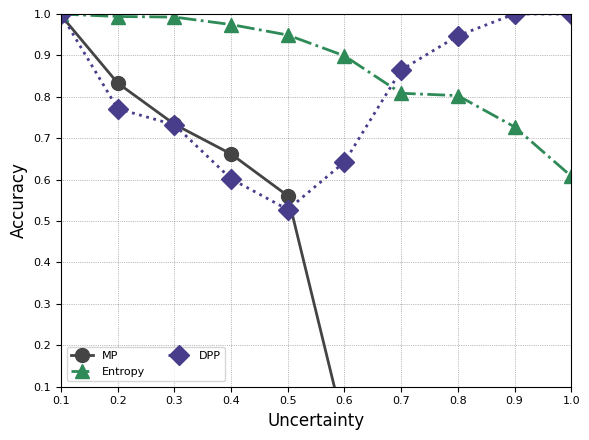

In [783]:
#ideal_line = np.arange(0.95, -0.05, -0.1)
x_values = np.arange(0.1, 1.1, 0.1)

plt.figure(figsize=(6, 4.5), dpi=100)
plt.xlabel('Uncertainty', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.xticks(np.arange(0, 1.1, 0.1), fontsize=8)
plt.yticks(np.arange(0, 1.1, 0.1), fontsize=8)
plt.ylim(0.1, 1)
plt.xlim(0.1, 1)
plt.grid(True, which='both', linestyle=':', linewidth=0.5, color='gray')

# Define a list of dark colors
dark_colors = ['#444444', '#8B4513', '#2E8B57', '#483D8B']

# Plot the data with different dark colors, line styles, and markers
line1, = plt.plot(x_values, uList_MP, color=dark_colors[0], linestyle='-', marker='o', markersize=10, linewidth=2, label='MP')
#line2, = plt.plot(x_values, uList_MP_MC, color=dark_colors[1], linestyle='--', marker='s', markersize=10, linewidth=2, label='MP_MC')
line3, = plt.plot(x_values, uList_Entropy_MC, color=dark_colors[2], linestyle='-.', marker='^', markersize=10, linewidth=2, label='Entropy')
line4, = plt.plot(x_values, uList_DPP, color=dark_colors[3], linestyle=':', marker='D', markersize=10, linewidth=2, label='DPP')


# Add a legend
plt.legend(handles=[line1, line3, line4], loc='lower left', fontsize=8, ncol=2)

# Show the plot
plt.tight_layout()
plt.show()

**All Counts**

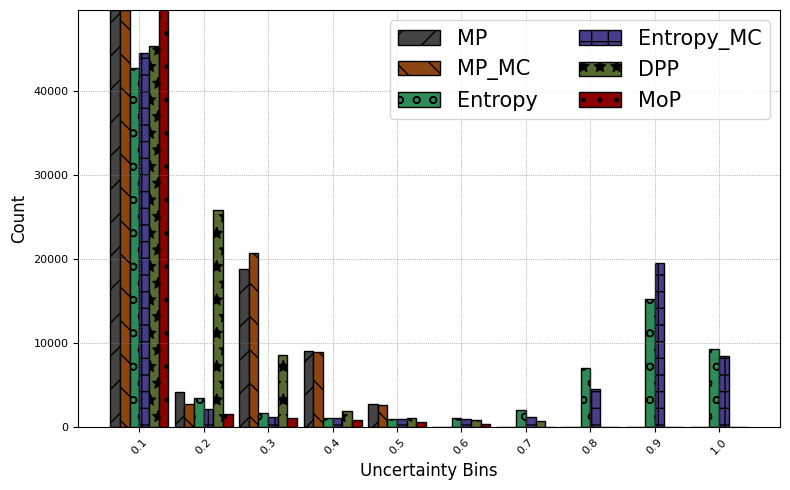

In [784]:
# Determine the maximum length and x values
max_length = len(uList_MP_count)
x_values = np.arange(0.1, 0.1 * max_length + 0.1, 0.1)
bar_width = 0.015  # Slightly wider bar width to space them out more

# Prepare the plot
plt.figure(figsize=(8, 5), dpi=100)
plt.xlabel('Uncertainty Bins', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(x_values, fontsize=8, rotation=45)  # Rotate x-axis labels for clarity
plt.yticks(fontsize=8)
plt.ylim(0, max(max(uList_MP_count), max(uList_DPP_count)) + 1)
#plt.xlim(0, max(x_values) + 0.2)  # Extend x-axis to make room on the sides
plt.grid(True, which='both', linestyle=':', linewidth=0.5, color='gray')

# Define a list of dark colors and hatch patterns for each bar
dark_colors = ['#444444', '#8B4513', '#2E8B57', '#483D8B', '#556B2F', '#8B0000']
hatches = ['/', '\\', 'o', '+', '*', '.']

# Plot each histogram with a unique color, hatch, and position, spread out for clarity
bar1 = plt.bar(x_values - 2.5 * bar_width, uList_MP_count, width=bar_width, color=dark_colors[0], hatch=hatches[0], label='MP', edgecolor='black')
bar2 = plt.bar(x_values - 1.5 * bar_width, uList_MP_MC_count, width=bar_width, color=dark_colors[1], hatch=hatches[1], label='MP_MC', edgecolor='black')
bar3 = plt.bar(x_values - 0.5 * bar_width, uList_Entropy_count, width=bar_width, color=dark_colors[2], hatch=hatches[2], label='Entropy', edgecolor='black')
bar4 = plt.bar(x_values + 0.5 * bar_width, uList_Entropy_MC_count, width=bar_width, color=dark_colors[3], hatch=hatches[3], label='Entropy_MC', edgecolor='black')
bar5 = plt.bar(x_values + 1.5 * bar_width, uList_DPP_count, width=bar_width, color=dark_colors[4], hatch=hatches[4], label='DPP', edgecolor='black')
bar6 = plt.bar(x_values + 2.5 * bar_width, uList_MoP_count, width=bar_width, color=dark_colors[5], hatch=hatches[5], label='MoP', edgecolor='black')

# Add a legend with more space to improve readability
plt.legend(handles=[bar1, bar2, bar3, bar4, bar5, bar6], loc='upper right', fontsize=15, ncol=2)

# Adjust layout to avoid clipping and overlap
plt.tight_layout()

# Show the plot
plt.show()

**All Counts Zoom In**

In [785]:
uList_MP_count = uList_MP_count[1:]
uList_MP_MC_count = uList_MP_MC_count[1:]
uList_Entropy_count = uList_Entropy_count[1:]
uList_Entropy_MC_count = uList_Entropy_MC_count[1:]
uList_DPP_count = uList_DPP_count[1:]
uList_MoP_count = uList_MoP_count[1:]

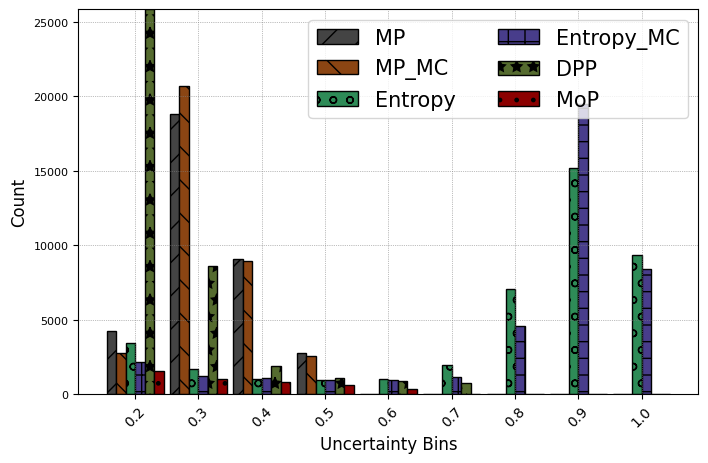

In [786]:
# Determine the maximum length and x values
max_length = len(uList_MP_count)
x_values = np.arange(0.2, 1.1, 0.1)
bar_width = 0.015  # Slightly wider bar width to space them out more

# Prepare the plot
plt.figure(figsize=(8, 5), dpi=100)
plt.xlabel('Uncertainty Bins', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(x_values, fontsize=10, rotation=45)  # Rotate x-axis labels for clarity
plt.yticks(fontsize=8)
plt.ylim(0, max(max(uList_MP_count), max(uList_DPP_count)) + 1)
#plt.xlim(0, max(x_values) + 0.2)  # Extend x-axis to make room on the sides
plt.grid(True, which='both', linestyle=':', linewidth=0.5, color='gray')

# Define a list of dark colors and hatch patterns for each bar
dark_colors = ['#444444', '#8B4513', '#2E8B57', '#483D8B', '#556B2F', '#8B0000']
hatches = ['/', '\\', 'o', '+', '*', '.']

# Plot each histogram with a unique color, hatch, and position, spread out for clarity
bar1 = plt.bar(x_values - 2.5 * bar_width, uList_MP_count, width=bar_width, color=dark_colors[0], hatch=hatches[0], label='MP', edgecolor='black')
bar2 = plt.bar(x_values - 1.5 * bar_width, uList_MP_MC_count, width=bar_width, color=dark_colors[1], hatch=hatches[1], label='MP_MC', edgecolor='black')
bar3 = plt.bar(x_values - 0.5 * bar_width, uList_Entropy_count, width=bar_width, color=dark_colors[2], hatch=hatches[2], label='Entropy', edgecolor='black')
bar4 = plt.bar(x_values + 0.5 * bar_width, uList_Entropy_MC_count, width=bar_width, color=dark_colors[3], hatch=hatches[3], label='Entropy_MC', edgecolor='black')
bar5 = plt.bar(x_values + 1.5 * bar_width, uList_DPP_count, width=bar_width, color=dark_colors[4], hatch=hatches[4], label='DPP', edgecolor='black')
bar6 = plt.bar(x_values + 2.5 * bar_width, uList_MoP_count, width=bar_width, color=dark_colors[5], hatch=hatches[5], label='MoP', edgecolor='black')

# Add a legend with more space to improve readability
plt.legend(handles=[bar1, bar2, bar3, bar4, bar5, bar6], loc='upper right', fontsize=15, ncol=2)

# Show the plot
plt.show()

**MP,Entropy,DPP Counts**

In [787]:
"""
# Determine the maximum length
max_length = len(uList_MP)

# Generate x values based on the maximum length, each interval is 0.1
x_values = np.arange(0.1, 0.1 * max_length + 0.1, 0.1)

bar_width = 0.03  # Set the width of each bar

plt.figure(figsize=(6, 4.5), dpi=100)
plt.xlabel('Uncertainty Bins', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(x_values, fontsize=8)  # Set x-axis tick size to match previous plot style
plt.yticks(fontsize=8)  # Set y-axis tick size to match previous plot style
plt.ylim(0, max(max(uList_MP_count), max(uList_DPP_count)) + 1)  # Set y-axis range
plt.grid(True, which='both', linestyle=':', linewidth=0.5, color='gray')

# Define a list of darker colors with higher contrast
dark_colors = ['#444444', '#8B4513', '#2E8B57', '#483D8B']  # Dark gray, saddle brown, sea green, dark slate blue
hatches = ['/', '\\', 'o', '+']  # Distinct hatch patterns for easy recognition

# Plot the histograms with hatch patterns for better visibility in black and white
bar1 = plt.bar(x_values - 1 * bar_width, uList_MP_count, width=bar_width, color=dark_colors[0], hatch=hatches[0], label='MP', edgecolor='black')
#bar2 = plt.bar(x_values - 0.5 * bar_width, uList_MP_MC_count, width=bar_width, color=dark_colors[1], hatch=hatches[1], label='MP_MC', edgecolor='black')
bar3 = plt.bar(x_values, uList_Entropy_MC_count, width=bar_width, color=dark_colors[2], hatch=hatches[2], label='Entropy', edgecolor='black')
bar4 = plt.bar(x_values + 1 * bar_width, uList_DPP_count, width=bar_width, color=dark_colors[3], hatch=hatches[3], label='DPP', edgecolor='black')

# Add a legend
plt.legend(handles=[bar1, bar3, bar4], loc='upper right', fontsize=8)

# Adjust layout to avoid clipping
plt.tight_layout()

# Show the plot
plt.show()
"""

"\n# Determine the maximum length\nmax_length = len(uList_MP)\n\n# Generate x values based on the maximum length, each interval is 0.1\nx_values = np.arange(0.1, 0.1 * max_length + 0.1, 0.1)\n\nbar_width = 0.03  # Set the width of each bar\n\nplt.figure(figsize=(6, 4.5), dpi=100)\nplt.xlabel('Uncertainty Bins', fontsize=12)\nplt.ylabel('Count', fontsize=12)\nplt.xticks(x_values, fontsize=8)  # Set x-axis tick size to match previous plot style\nplt.yticks(fontsize=8)  # Set y-axis tick size to match previous plot style\nplt.ylim(0, max(max(uList_MP_count), max(uList_DPP_count)) + 1)  # Set y-axis range\nplt.grid(True, which='both', linestyle=':', linewidth=0.5, color='gray')\n\n# Define a list of darker colors with higher contrast\ndark_colors = ['#444444', '#8B4513', '#2E8B57', '#483D8B']  # Dark gray, saddle brown, sea green, dark slate blue\nhatches = ['/', '\\', 'o', '+']  # Distinct hatch patterns for easy recognition\n\n# Plot the histograms with hatch patterns for better visibili

In [788]:
#Zoom in
uList_MP_count = uList_MP_count[1:]
uList_Entropy_MC_count = uList_Entropy_MC_count[1:]
uList_DPP_count = uList_DPP_count[1:]

In [789]:
"""
# Determine the maximum length
max_length = len(uList_MP)

# Generate x values based on the maximum length, each interval is 0.1
x_values = np.arange(0.2, 0.1 * max_length + 0.1, 0.1)

bar_width = 0.03  # Set the width of each bar

plt.figure(figsize=(6, 4.5), dpi=100)
plt.xlabel('Uncertainty Bins', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(x_values, fontsize=8)  # Set x-axis tick size to match previous plot style
plt.yticks(fontsize=8)  # Set y-axis tick size to match previous plot style
plt.ylim(0, max(max(uList_MP_count), max(uList_DPP_count)) + 1)  # Set y-axis range
plt.grid(True, which='both', linestyle=':', linewidth=0.5, color='gray')

# Define a list of darker colors with higher contrast
dark_colors = ['#444444', '#8B4513', '#2E8B57', '#483D8B']  # Dark gray, saddle brown, sea green, dark slate blue
hatches = ['/', '\\', 'o', '+']  # Distinct hatch patterns for easy recognition

# Plot the histograms with hatch patterns for better visibility in black and white
bar1 = plt.bar(x_values - 1 * bar_width, uList_MP_count, width=bar_width, color=dark_colors[0], hatch=hatches[0], label='MP', edgecolor='black')
#bar2 = plt.bar(x_values - 0.5 * bar_width, uList_MP_MC_count, width=bar_width, color=dark_colors[1], hatch=hatches[1], label='MP_MC', edgecolor='black')
bar3 = plt.bar(x_values, uList_Entropy_MC_count, width=bar_width, color=dark_colors[2], hatch=hatches[2], label='Entropy', edgecolor='black')
bar4 = plt.bar(x_values + 1 * bar_width, uList_DPP_count, width=bar_width, color=dark_colors[3], hatch=hatches[3], label='DPP', edgecolor='black')

# Add a legend
plt.legend(handles=[bar1, bar3, bar4], loc='upper right', fontsize=8)

# Adjust layout to avoid clipping
plt.tight_layout()

# Show the plot
plt.show()
"""

"\n# Determine the maximum length\nmax_length = len(uList_MP)\n\n# Generate x values based on the maximum length, each interval is 0.1\nx_values = np.arange(0.2, 0.1 * max_length + 0.1, 0.1)\n\nbar_width = 0.03  # Set the width of each bar\n\nplt.figure(figsize=(6, 4.5), dpi=100)\nplt.xlabel('Uncertainty Bins', fontsize=12)\nplt.ylabel('Count', fontsize=12)\nplt.xticks(x_values, fontsize=8)  # Set x-axis tick size to match previous plot style\nplt.yticks(fontsize=8)  # Set y-axis tick size to match previous plot style\nplt.ylim(0, max(max(uList_MP_count), max(uList_DPP_count)) + 1)  # Set y-axis range\nplt.grid(True, which='both', linestyle=':', linewidth=0.5, color='gray')\n\n# Define a list of darker colors with higher contrast\ndark_colors = ['#444444', '#8B4513', '#2E8B57', '#483D8B']  # Dark gray, saddle brown, sea green, dark slate blue\nhatches = ['/', '\\', 'o', '+']  # Distinct hatch patterns for easy recognition\n\n# Plot the histograms with hatch patterns for better visibili

# *Count Difference*

**BD-rate Like Metric**

In [790]:
def diff_p(id_line,cp_line):
    A_id = 0.0
    A_cp = 0.0

    for i in range(1,10):
        A_id += (id_line[i-1] + id_line[i]) * 0.1 * 0.5
        A_cp += (cp_line[i-1] + cp_line[i]) * 0.1 * 0.5

    
    print(A_id)
    print(A_cp)

    diff = A_id - A_cp
    print(A_cp/diff)
    print(A_id/diff)

    return (A_cp - A_id)/diff

In [791]:
print(diff_p(IL,uList_Entropy_MC))

0.4994682402845103
0.7952431323954787
-2.6886769418450855
-1.6886769418450858
-1.0


In [792]:
#MP vs. MP_MC
diff = []
for i in range(10):
    if (uList_MP_MC[i] == 0 and uList_MP[i] == 0):
        break;
    diff.append(uList_MP_MC[i] - uList_MP[i]) 
print(diff)
print("Average Diff for Entropy:",np.mean(diff))
print("Average Diff for Entropy in low uncertainties:",np.mean(diff[:2]))
print("Maximum Diff for Entropy:",max(diff))

[0.0015314805233517248, 0.018742518042206835, 0.01045024103721015, -0.01702311286685043, -0.03614447800560139]
Average Diff for Entropy: -0.004488670253936622
Average Diff for Entropy in low uncertainties: 0.01013699928277928
Maximum Diff for Entropy: 0.018742518042206835


In [793]:
#Entropy vs. Entropy_MC
diff = []
for i in range(10):
    if (uList_Entropy_MC[i] == 0 and uList_Entropy[i] == 0):
        break;
    diff.append(uList_Entropy_MC[i] - uList_Entropy[i])
print(diff)
print("Average Diff for Entropy:",np.mean(diff))
print("Average Diff for Entropy in low uncertainties:",np.mean(diff[:2]))
print("Maximum Diff for Entropy:",max(diff))

[0.000380626891071989, 0.0003114161364469181, 0.015666248873917987, 0.009114473868572226, 0.020745592650851408, 0.015226161011829387, -0.0048737703236264585, 0.0481128670675709, 0.008189079184184322, -0.01603407818273772]
Average Diff for Entropy: 0.009683861717808096
Average Diff for Entropy in low uncertainties: 0.00034602151375945356
Maximum Diff for Entropy: 0.0481128670675709


In [ ]:
# MP vs. Entropy
diff = []
for i in range(8):
    diff.append(IL[i] - uList_Entropy_MC[i])
print(diff)
print("Average Diff for Entropy_MC:",np.mean(diff))
print("Average Diff for Entropy_MC in low uncertainties:",np.mean(diff[:2]))
print("Maximum Diff for Entropy_MC:",max(diff))

[0.001315789473684159, 0.010899053627760225, 0.05070004861448707, 0.16132390096008076, 0.21422969187675067, 0.19494934876989878, 0.15937499999999993, 0.1971681415929204]
Average Diff for Entropy_MC: 0.12374512186444775
Average Diff for Entropy_MC in low uncertainties: 0.006107421550722192
Maximum Diff for Entropy_MC: 0.21422969187675067


In [ ]:
# MP vs. DPP
diff = []
for i in range(8):
    diff.append(IL[i]-uList_DPP[i])
print(diff)
print("Average Diff for DPP:",np.mean(diff))
print("Average Diff for DPP in low uncertainties:",np.mean(diff[:2]))
print("Maximum Diff for DPP:",max(diff))

[0.0003376097231599928, -0.001919191919191876, 0.018721659430776638, 0.0792020815264527, 0.10748681898066781, 0.08513586956521746, -0.022650231124807463, -0.14222222222222214]
Average Diff for DPP: 0.01551154924500664
Average Diff for DPP in low uncertainties: -0.0007907910980159416
Maximum Diff for DPP: 0.10748681898066781


In [ ]:
# MP vs. Entropy
diff = []
for i in range(8):
    diff.append(uList_Entropy_MC[i] - uList_MP[i])
print(diff)
print("Average Diff for Entropy:",np.mean(diff))
print("Average Diff for Entropy in low uncertainties:",np.mean(diff[:2]))
print("Maximum Diff for Entropy:",max(diff))

[0.015318605879246716, 0.12708583302211385, 0.13758206328464606, 0.10714325232459077, 0.12679911470761152, 0.13088775530249946, 0.20222195817490496, 0.04465004022526148]
Average Diff for Entropy: 0.11146107786510935
Average Diff for Entropy in low uncertainties: 0.07120221945068028
Maximum Diff for Entropy: 0.20222195817490496


In [ ]:
# MP vs. DPP
diff = []
for i in range(8):
    diff.append(uList_DPP[i] - uList_MP[i])
print(diff)
print("Average Diff for DPP:",np.mean(diff))
print("Average Diff for DPP in low uncertainties:",np.mean(diff[:2]))
print("Maximum Diff for DPP:",max(diff))

[0.016296785629770882, 0.13990407856906595, 0.1695604524683565, 0.18926507175821883, 0.23354198760369438, 0.24070123450718078, 0.38424718929971236, 0.384040404040404]
Average Diff for DPP: 0.21969465048455045
Average Diff for DPP in low uncertainties: 0.07810043209941842
Maximum Diff for DPP: 0.38424718929971236


0.2265650661 + 0.1272215395 + 0.1114610779 + 0.2196946505

In [ ]:
(0.2265650661 + 0.1272215395 + 0.1114610779 + 0.2196946505)/4

0.17123558349999998